<a href="https://colab.research.google.com/github/marcio-lfo/devai/blob/main/Grupo3_projeto1_tarefa1_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto 1 - Classificação de Decisões Judiciais**

**Abordagens tradicionais de Aprendizado de Máquina e Modelos Neurais de Linguagens**

Grupo 3

# **Tarefa 1 - parte 1**

**Objetivo**: Estender os códigos desenvolvidos em sala
para incorporar novos algoritmos e configurações.

**Opção do Vectorizer : TF-IDF**

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('joelniklaus/brazilian_court_decisions')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 404
    })
    test: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 405
    })
})

In [ ]:
dataset['train'][0]

{'process_number': '0800304-08.2018.8.02.0000',
 'orgao_julgador': 'Tribunal Pleno',
 'publish_date': '12/03/2019',
 'judge_relator': 'Des. João Luiz Azevedo Lessa',
 'ementa_text': 'DIREITO PENAL E PROCESSUAL PENAL. REVISÃO CRIMINAL. ART. 621 DO CÓDIGO DE PROCESSO PENAL. REQUERENTE CONDENADO EM JÚRI POPULAR PELA PRÁTICA DOS CRIMES DE HOMICÍDIO DUPLAMENTE QUALIFICADO E HOMICÍDIO QUALIFICADO TENTADO. PLEITO DE REFAZIMENTO DA DOSIMETRIA DA PENA IMPOSTA AO REQUERENTE. ADMISSIBILIDADE NA VIA REVISIONAL. PRECEDENTES. ALEGAÇÃO DE ERRO NO PROCESSO DE DOSIMETRIA DA PENA. COMPORTAMENTO DA VÍTIMA. CIRCUNSTÂNCIA JUDICIAL NEUTRA QUE NÃO PODE SER CONSIDERADA DE FORMA DESFAVORÁVEL AO SENTENCIANDO SEGUNDO PRECEDENTES DO SUPERIOR TRIBUNAL DE JUSTIÇA E NOVO ENTENDIMENTO DA CÂMARA CRIMINAL DESTE TRIBUNAL DE JUSTIÇA. AFASTAMENTO. CULPABILIDADE. AUSÊNCIA DE EXPOSIÇÃO DE MOTIVOS PARA O INCREMENTO DA PENA-BASE. AFASTADO O DESVALOR. VALORAÇÃO ATRIBUÍDA ÀS CIRCUNSTÂNCIAS DO CRIME MANTIDA. FUNDAMENTAÇÃO IDÔNEA

In [ ]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels = dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')


Train size: 3234 -- 3234
Test size: 405 -- 405


In [ ]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [ ]:
!python -m spacy download pt_core_news_sm

2023-12-03 12:03:30.575823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 12:03:30.575891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 12:03:30.575934: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 12:03:30.583884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 12:03:31.662356: W tensorflow/c

In [ ]:
import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

In [ ]:
train_texts = preprocess_texts(train_texts)

Preprocessing: 100%|██████████| 3234/3234 [00:48<00:00, 66.10it/s]


In [ ]:
test_texts = preprocess_texts(test_texts)

Preprocessing: 100%|██████████| 405/405 [00:06<00:00, 58.73it/s]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorizer_option = 'binary'
# vectorizer_option = 'count'
vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  # Vetorizador de contagem simples
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'tf_idf':
  # Vetorizador usando TF-IDF
  vectorizer = TfidfVectorizer(max_features=None, ngram_range=(1, 1))

In [ ]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(f'Opção do Vectorizer: {vectorizer_option}')
print(f'Tamanho do Vocabulário: {len(vectorizer.vocabulary_)}')

if vectorizer_option == 'count':
    # Obtém a contagem de palavras para cada documento
    word_counts = X_train.sum(axis=1).ravel()
    # Mostra algumas estatísticas sobre o vocabulário e as contagens de palavras dos 10 primeiros documentos
    print(f'Contagem de Palavras dos primeiros 10 Documentos: {word_counts[:10]}')

if vectorizer_option == 'tf_idf':
    idf_values = vectorizer.idf_

    # Mostra algumas estatísticas sobre o vocabulário e as contagens de palavras (ou valores TF-IDF) dos 10 primeiros termos
    print(f'Valores IDF para o Vocabulário dos 10 primeiros termos: {idf_values[:10]}')

Opção do Vectorizer: tf_idf
Tamanho do Vocabulário: 12447
Valores IDF para o Vocabulário dos 10 primeiros termos: [3.35168442 7.69548985 8.38863703 8.38863703 8.38863703 8.38863703
 8.38863703 7.98317192 7.29002474 8.38863703]


In [ ]:
# Incluindo novos algoritmos

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'MLP': MLPClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LDA': LinearDiscriminantAnalysis()
}


Classifier: Logistic Regression
              precision    recall  f1-score   support

           0    0.84390   0.73932   0.78815       234
           1    0.56034   0.69892   0.62201        93
           2    0.58333   0.62821   0.60494        78

    accuracy                        0.70864       405
   macro avg    0.66253   0.68882   0.67170       405
weighted avg    0.72861   0.70864   0.71472       405



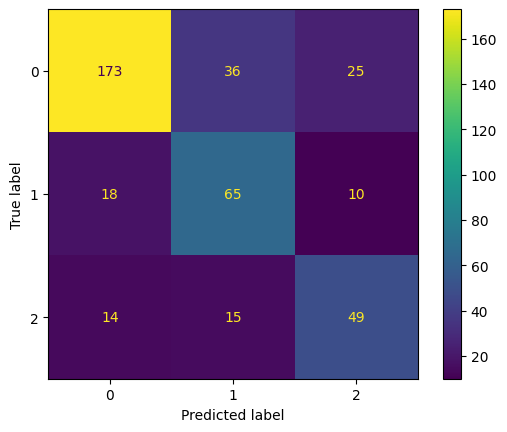


Classifier: Multinomial NB


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.60477   0.97436   0.74632       234
           1    0.75000   0.22581   0.34711        93
           2    0.00000   0.00000   0.00000        78

    accuracy                        0.61481       405
   macro avg    0.45159   0.40006   0.36447       405
weighted avg    0.52165   0.61481   0.51091       405



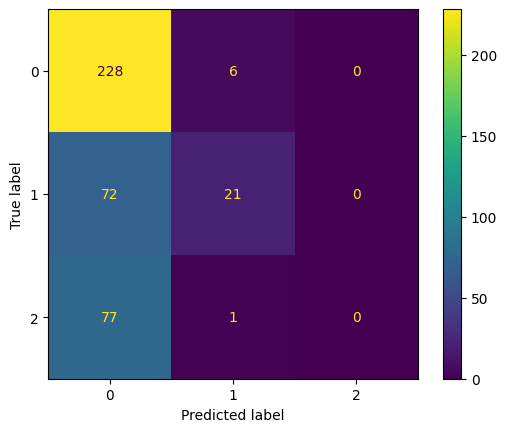


Classifier: KNN


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    1.00000   0.00427   0.00851       234
           1    0.23020   1.00000   0.37425        93
           2    0.00000   0.00000   0.00000        78

    accuracy                        0.23210       405
   macro avg    0.41007   0.33476   0.12759       405
weighted avg    0.63064   0.23210   0.09086       405



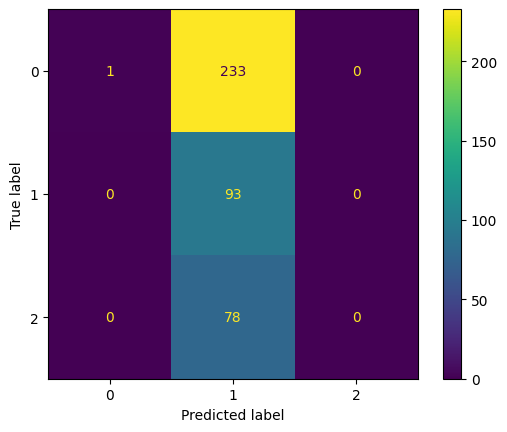


Classifier: Random Forest
              precision    recall  f1-score   support

           0    0.71885   0.96154   0.82267       234
           1    0.77193   0.47312   0.58667        93
           2    0.82857   0.37179   0.51327        78

    accuracy                        0.73580       405
   macro avg    0.77312   0.60215   0.64087       405
weighted avg    0.75217   0.73580   0.70889       405



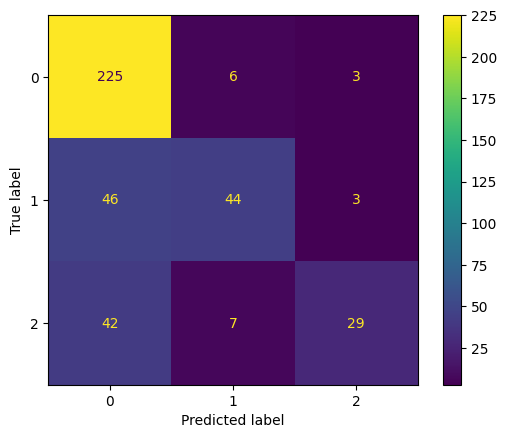


Classifier: Gradient Boosting
              precision    recall  f1-score   support

           0    0.71947   0.93162   0.81192       234
           1    0.71429   0.48387   0.57692        93
           2    0.69231   0.34615   0.46154        78

    accuracy                        0.71605       405
   macro avg    0.70869   0.58722   0.61679       405
weighted avg    0.71305   0.71605   0.69048       405



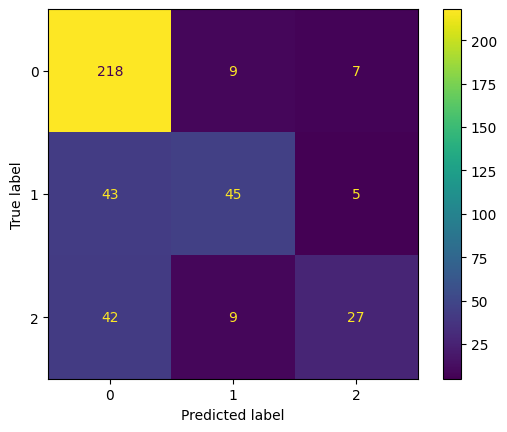


Classifier: SVM
              precision    recall  f1-score   support

           0    0.68308   0.94872   0.79428       234
           1    0.70690   0.44086   0.54305        93
           2    0.90909   0.25641   0.40000        78

    accuracy                        0.69877       405
   macro avg    0.76635   0.54866   0.57911       405
weighted avg    0.73208   0.69877   0.66065       405



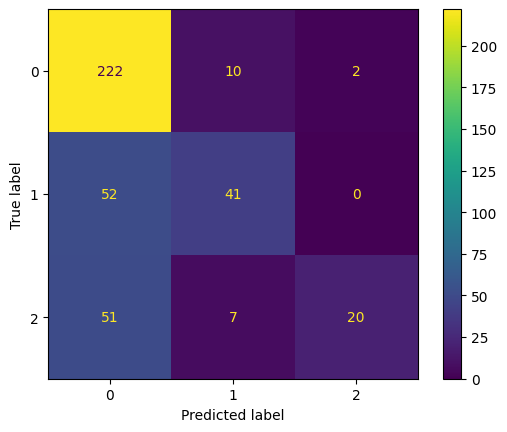


Classifier: Decision Tree
              precision    recall  f1-score   support

           0    0.76695   0.77350   0.77021       234
           1    0.54545   0.58065   0.56250        93
           2    0.57143   0.51282   0.54054        78

    accuracy                        0.67901       405
   macro avg    0.62794   0.62232   0.62442       405
weighted avg    0.67843   0.67901   0.67828       405



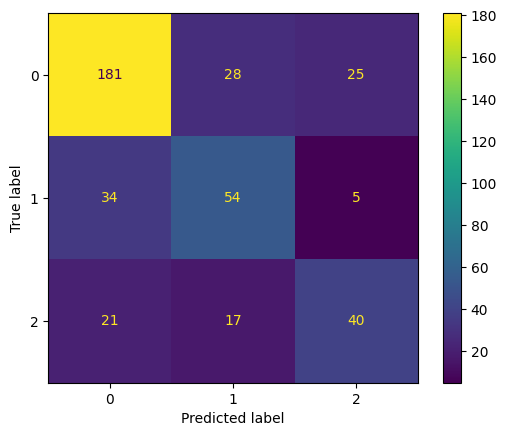


Classifier: MLP
              precision    recall  f1-score   support

           0    0.79921   0.86752   0.83197       234
           1    0.66304   0.65591   0.65946        93
           2    0.61017   0.46154   0.52555        78

    accuracy                        0.74074       405
   macro avg    0.69081   0.66166   0.67232       405
weighted avg    0.73154   0.74074   0.73334       405



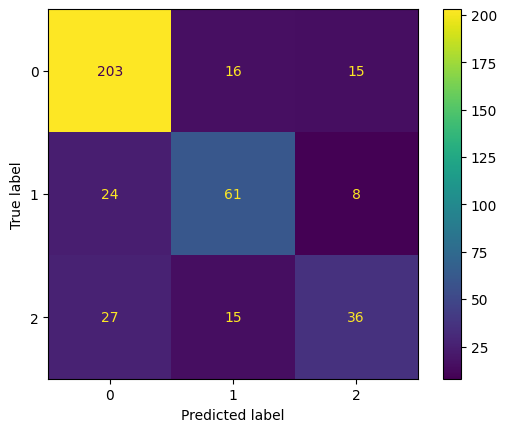


Classifier: AdaBoost
              precision    recall  f1-score   support

           0    0.71777   0.88034   0.79079       234
           1    0.62121   0.44086   0.51572        93
           2    0.55769   0.37179   0.44615        78

    accuracy                        0.68148       405
   macro avg    0.63222   0.56433   0.58422       405
weighted avg    0.66477   0.68148   0.66125       405



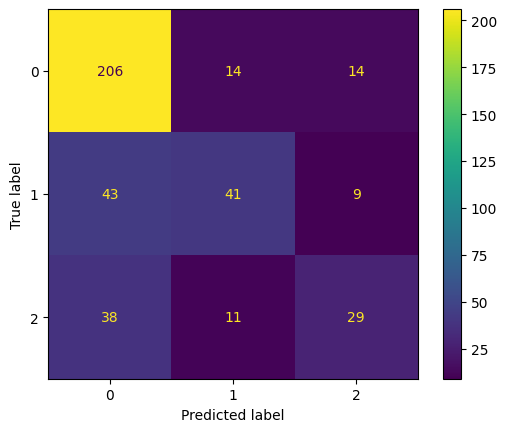


Classifier: LDA
              precision    recall  f1-score   support

           0    0.75135   0.59402   0.66348       234
           1    0.47000   0.50538   0.48705        93
           2    0.39167   0.60256   0.47475        78

    accuracy                        0.57531       405
   macro avg    0.53767   0.56732   0.54176       405
weighted avg    0.61747   0.57531   0.58662       405



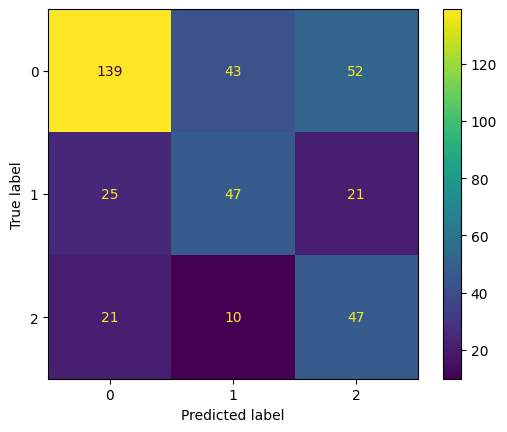

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

for classifier_name, classifier in classifiers.items():

  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred, digits=5)

  print(report)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()

  """
    Gerar os resultados do classification_report para cada um dos 10 algoritmos.
    Montar uma planilha com os resultados das medidas (Acurácia e weighted avg
    da Precisão, Cobertura e F1-Score).
    Destacar em negrito o melhor algoritmo para cada medida de avaliação.
  """

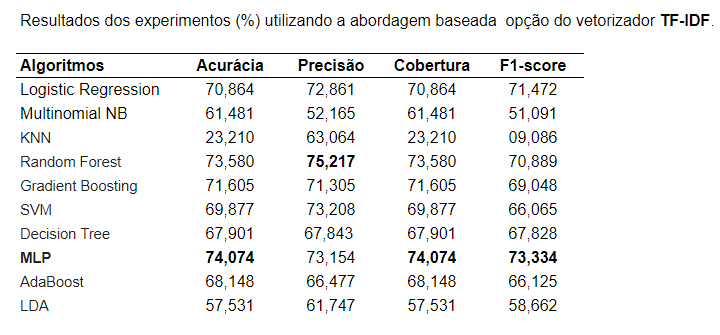

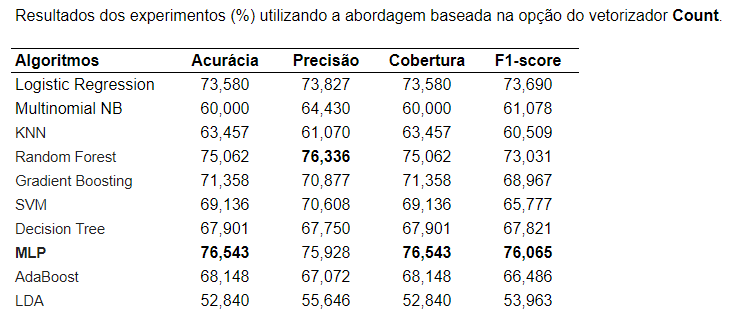

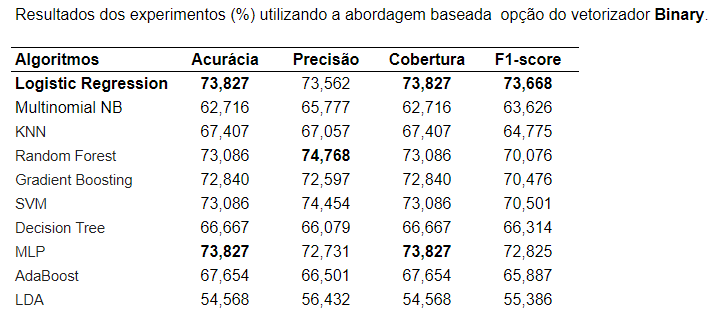